In [7]:
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import pandas as pd
from pathlib import Path
from evaluation.cross_tool_analysis import load_proverbot, load_tactician, load_rango, get_unique_files, get_mutual_proof_pairs, NamedEval, get_two_eval_subsets, SuccessfulResult, GeneralResult

In [8]:
if Path(os.curdir).resolve().name == "evaluation":
    os.chdir("../..")
elif Path(os.curdir).resolve().name == "coq-modeling": 
    pass
else:
    raise ValueError(f"In an unexpected directory: {os.curdir}")

In [11]:
PROVERBOT_LOC = Path("evaluations/proverbot")
TACTICIAN_LOC = Path("evaluations/tactician/results-24-07-22")
RANGO_LOC = Path("evaluations/eval-results/deepseek-bm-25-proof-ret-final-test-500")
#RANGO_LOC = Path("evaluations/eval-results/deepseek-proof-prem-final-test-500")
#RANGO_LOC = Path("evaluations/eval-results/deepseek-proof-final-test-500")

In [12]:
proverbot_eval = NamedEval("proverbot", load_proverbot(PROVERBOT_LOC))
proverbot_files = get_unique_files(proverbot_eval.results)

tactician_eval = NamedEval("tactician", load_tactician(TACTICIAN_LOC, proverbot_files))
rango_eval = NamedEval("rango", load_rango(RANGO_LOC, proverbot_files))

In [13]:
raw_evals = [
    proverbot_eval,
    tactician_eval,
    #rango_eval,
]

In [14]:
[r.theorem for r in tactician_eval.results][:10]

['Theorem compare_refl {A:Type} (C: Comparable A) : forall x, compare x x = Eq.',
 'Global Instance ComparableLtStrictOrder {A:Type} (C: Comparable A) : StrictOrder (comparableLt C).',
 'Next Obligation.',
 'Lemma compare_sym x y : (y?=x) = CompOpp (x?=y).',
 'Lemma compare_trans c x y z : (x?=y) = c -> (y?=z) = c -> (x?=z) = c.',
 'Next Obligation.',
 'Next Obligation.',
 'Next Obligation.',
 'Next Obligation.',
 'Theorem compare_eqb_iff {A:Type} {C:Comparable A} {U:ComparableLeibnizEq C} : forall x y, compare_eqb x y = true <-> x = y.']

In [15]:
[r.file for r in tactician_eval.results][:10]

[PosixPath('AbsInt-CompCert/MenhirLib/Alphabet.v'),
 PosixPath('AbsInt-CompCert/MenhirLib/Alphabet.v'),
 PosixPath('AbsInt-CompCert/MenhirLib/Alphabet.v'),
 PosixPath('AbsInt-CompCert/MenhirLib/Alphabet.v'),
 PosixPath('AbsInt-CompCert/MenhirLib/Alphabet.v'),
 PosixPath('AbsInt-CompCert/MenhirLib/Alphabet.v'),
 PosixPath('AbsInt-CompCert/MenhirLib/Alphabet.v'),
 PosixPath('AbsInt-CompCert/MenhirLib/Alphabet.v'),
 PosixPath('AbsInt-CompCert/MenhirLib/Alphabet.v'),
 PosixPath('AbsInt-CompCert/MenhirLib/Alphabet.v')]

In [16]:
[r.theorem for r in proverbot_eval.results][:10]

['Theorem Ackermann: forall n m : nat, {p : nat | Ack n m p}.',
 'Theorem Ack_ack: forall n m : nat, Ack n m (ack n m).',
 'Theorem ack_Ack: forall n m p : nat, Ack n m p -> p = ack n m :>nat.',
 'Lemma skip_step_sem s1 (S : skip_safe s1) s2 r: skip_step S s2 r -> network_step W this s1 s2.',
 'Lemma skip_safe_coh s1 : skip_safe s1 -> Coh W s1.',
 "(* Lemma skip_step_safe s1 s2 r: skip_step s1 s2 r -> skip_safe s1. *) (* Proof. by case. Qed. *) Lemma skip_step_total s (S : skip_safe s) : exists s' r, skip_step S s' r.",
 "Lemma send_act_step_total s (S: send_act_safe s): exists s' r , send_act_step S s' r.",
 'Lemma safe_local s : skip_safe s -> coh p (getS s l).',
 'Lemma tryrecv_act_safe_coh s : tryrecv_act_safe s -> Coh W s.',
 'Lemma safe_safe s : send_act_safe s -> send_safe st this to (getS s l) msg.']

In [17]:
[r.file for r in proverbot_eval.results][:10]

[PosixPath('demos/Ack.v'),
 PosixPath('demos/Ack.v'),
 PosixPath('demos/Ack.v'),
 PosixPath('disel/Core/Actions.v'),
 PosixPath('disel/Core/Actions.v'),
 PosixPath('disel/Core/Actions.v'),
 PosixPath('disel/Core/Actions.v'),
 PosixPath('disel/Core/Actions.v'),
 PosixPath('disel/Core/Actions.v'),
 PosixPath('disel/Core/Actions.v')]

In [18]:
mutual_proofs = get_mutual_proof_pairs(raw_evals)
evals = [e.filter_results(mutual_proofs) for e in raw_evals]
assert all(len(e.results) == len(mutual_proofs) for e in evals)

In [19]:
[len(e.results) for e in evals]

[428, 428]

In [20]:
len(mutual_proofs)

428

In [22]:

def attempts_by_project(e: NamedEval) -> dict[str, list[GeneralResult]]:
    grouped_results: dict[str, list[GeneralResult]] = {}
    for r in e.results: 
        project = r.file.parts[0]
        if project not in grouped_results:
            grouped_results[project] = []
        grouped_results[project].append(r)
    return grouped_results

def count_successes(results: list[GeneralResult]) -> int:
    return sum(1 for r in results if r.success)

rows: list[tuple[str, str, int, int, float]] = []
for e in evals:
    attempts_by_proj = attempts_by_project(e)
    for proj, attempts in attempts_by_project(e).items():
        n_successes = count_successes(attempts)
        n_attempts = len(attempts)
        p = n_successes / n_attempts
        rows.append((e.name, proj, n_successes, n_attempts, p))
pd.DataFrame(rows, columns=["System", "Project", "Successes", "Attempts", "Success Rate"])

ValueError: 4 columns passed, passed data had 5 columns

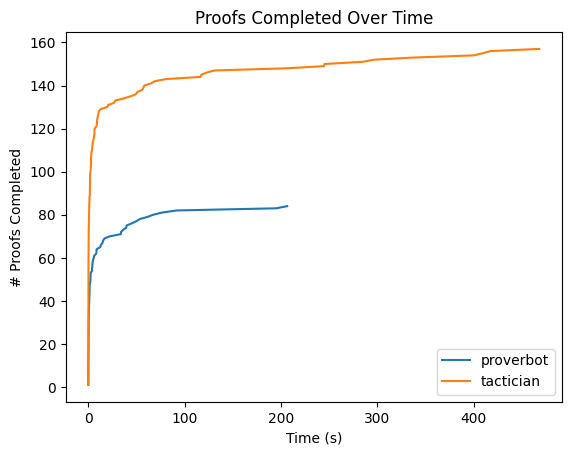

In [ ]:
def plot_times(es: list[NamedEval]):
    times = [e.get_time_points() for e in es]
    fig, ax = plt.subplots()
    for e, time_list in zip(es, times):
        xs = [t.x for t in time_list]
        ys = [t.y for t in time_list]
        ax.plot(xs, ys, label=e.name)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("# Proofs Completed")
    ax.set_title("Proofs Completed Over Time")
    ax.legend(loc="lower right")


plot_times(evals)

Total # Found =  166


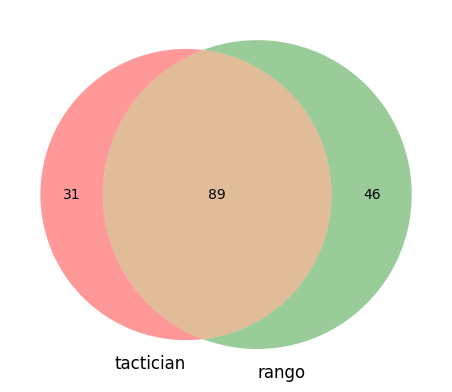

In [ ]:
def compare_two(es: list[NamedEval], e1_alias: str, e2_alias: str) -> int:
    fig, ax = plt.subplots()
    subsets = get_two_eval_subsets(es, e1_alias, e2_alias)
    venn2((len(subsets.one_only), len(subsets.two_only), len(subsets.one_two)),
          set_labels=(e1_alias, e2_alias), ax=ax)
    get_two_eval_subsets(es, e1_alias, e2_alias)
    return len(subsets.one_only) + len(subsets.one_two) + len(subsets.two_only)


total_found = compare_two(evals, "tactician", "rango")
print("Total # Found = ", total_found)




In [ ]:
subsets = get_two_eval_subsets(evals, "tactician", "rango")

In [ ]:
import json
with open("tactician_only.json", "w") as fout:
    fout.write(json.dumps([{"file": str(s.file), "theorem": s.theorem} for s in subsets.one_only], indent=2))